<a href="https://colab.research.google.com/github/AkarshKollana/DBT_bq_demo/blob/dbt_new_branch/probability_and_statistics_moloco_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom, norm, chisquare
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

In [2]:
np.random.seed(13)

OUT_DIR = "moloco_stats_prep_plots"
os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
def _save_fig(name: str):
  path = os.path.join(OUT_DIR, name)
  plt.savefig(path, bbox_inches="tight", dpi=180)
  return path

In [4]:
def a_descriptive_stats():
    # Creative Level CTR distribution (skewed)
    n_creatives = 1200
    impr_per_creative = 8000

    # Indented properly to be inside the function
    mix = np.random.rand(n_creatives)
    p_ctr = np.where(mix < 0.92,
                     np.random.beta(2, 180, n_creatives),
                     np.random.beta(10, 60, n_creatives))
    clicks = np.random.binomial(impr_per_creative, p_ctr)
    return clicks / impr_per_creative

# We execute it here to create the 'ctr' variable for the next cells
ctr = a_descriptive_stats()

In [5]:
mean_ctr = float(np.mean(ctr))
median_ctr = float(np.median(ctr))
std_ctr = float(np.std(ctr))
p90_ctr = float(np.percentile(ctr, 90))

In [6]:
mean_ctr, median_ctr, std_ctr, p90_ctr

(0.021585104166666664, 0.01025, 0.038346760232145415, 0.03253750000000005)

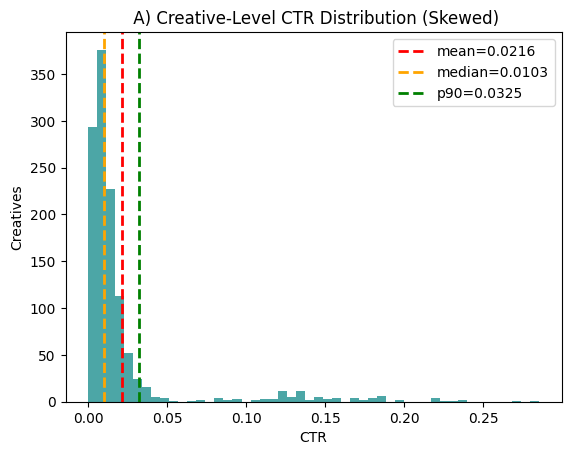

In [7]:
plt.figure()
plt.hist(ctr, bins = 50, color='teal', alpha=0.7)
plt.axvline(mean_ctr, color = 'red', linestyle = "--", linewidth=2, label=f"mean={mean_ctr:.4f}")
plt.axvline(median_ctr, color = 'orange', linestyle="--", linewidth=2, label=f"median={median_ctr:.4f}")
plt.axvline(p90_ctr, color = 'green', linestyle="--", linewidth=2, label=f"p90={p90_ctr:.4f}")
plt.title(" A) Creative-Level CTR Distribution (Skewed)")
plt.xlabel("CTR")
plt.ylabel("Creatives")
plt.legend()
_save_fig("A_ctr_distribution_mean_median_p90.png") # Removed if not defined
plt.show()
plt.close()

In [8]:
# Expected Value vs Bid (CPC)
q0 = 0.6
p_clicks0 = 0.004 + 0.02*q0
p_conv0 = 0.06 + 0.22*q0
value0 = float(np.exp(3.2 + 0.7*q0))
bid_grid = np.linspace(0.5, 10.0, 60)
ev_vs_bid = p_clicks0 * (p_conv0 * value0 - bid_grid)

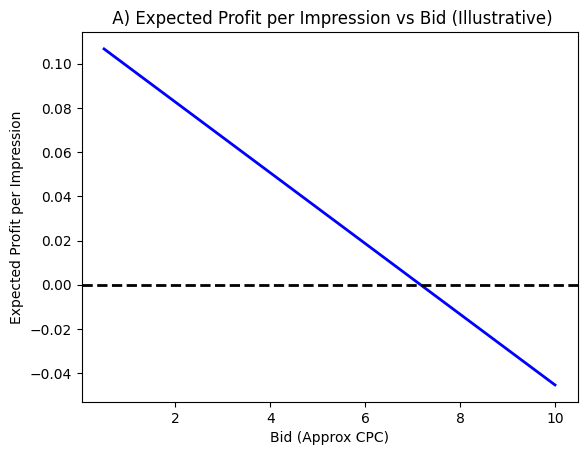

In [9]:
plt.figure()
plt.plot(bid_grid, ev_vs_bid, color='blue', linewidth=2)
plt.axhline(0, color='black', linestyle = "--", linewidth = 2)
plt.title(" A) Expected Profit per Impression vs Bid (Illustrative)")
plt.xlabel("Bid (Approx CPC)")
plt.ylabel("Expected Profit per Impression")
_save_fig("A_ev_vs_bid.png") # Removed if not defined
plt.show()
plt.close()

In [10]:


def b_distributions():
  # Binomial vs normal approximation for clicks
  n_impr = 1000
  p = 0.02
  x = np.arange(0, 70)
  pmf = binom.pmf(x, n_impr, p)
  mu = n_impr * p
  sigma = math.sqrt(n_impr * p * (1 - p))
  pdf = norm.pdf(x, mu, sigma)

  return {"mu": mu, "sigma": sigma}

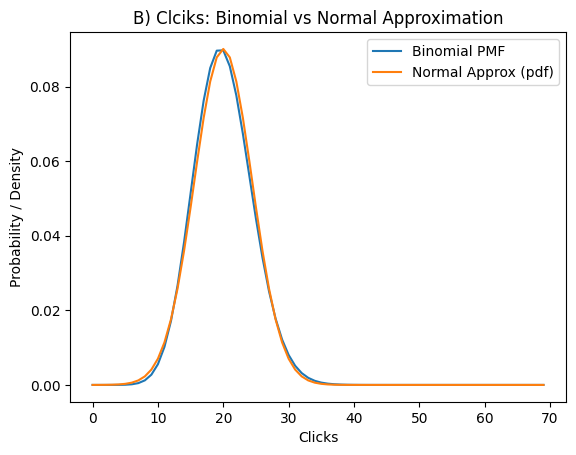

In [11]:
  n_impr = 1000
  p = 0.02
  x = np.arange(0, 70)
  pmf = binom.pmf(x, n_impr, p)
  mu = n_impr * p
  sigma = math.sqrt(n_impr * p * (1 - p))
  pdf = norm.pdf(x, mu, sigma)

  plt.figure()
  plt.plot(x, pmf, label="Binomial PMF")
  plt.plot(x, pdf, label="Normal Approx (pdf)")
  plt.title("B) Clciks: Binomial vs Normal Approximation")
  plt.xlabel("Clicks")
  plt.ylabel("Probability / Density")
  plt.legend()
  _save_fig("B_clicks_binomial_vs_normal.png")
  plt.show()
  plt.close()

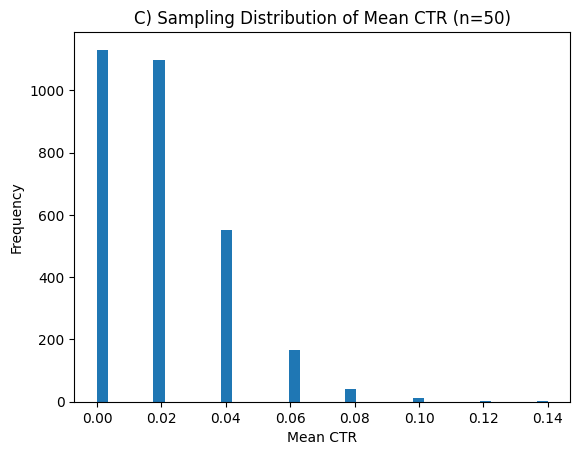

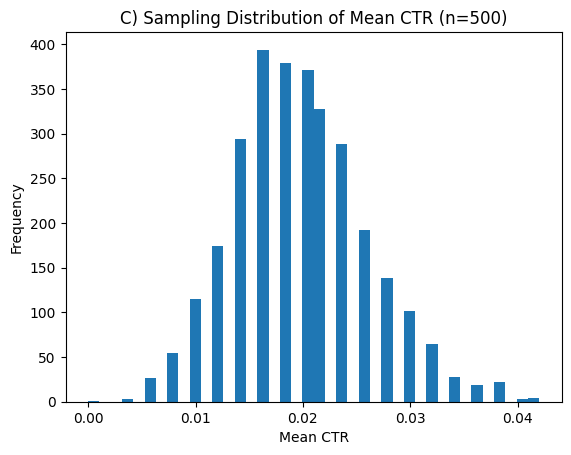

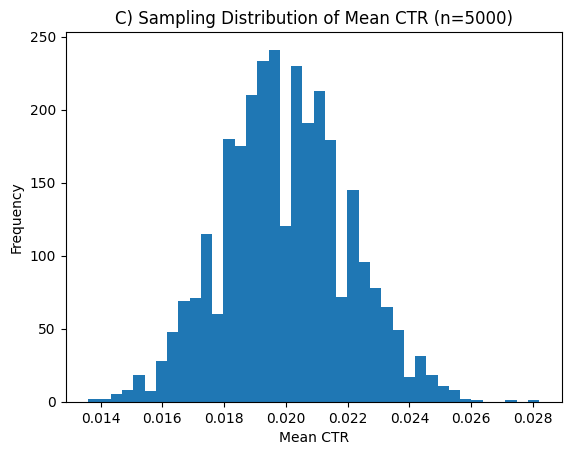

In [12]:
def c_lln_clt_optional_stoping():
  # CLT: sampling distribution of mean CTR
  p_true = 0.02
  for n in [50, 500, 5000]:
    means = [np.mean(np.random.binomial(1, p_true, size = n)) for _ in range(3000)]
    plt.figure()
    plt.hist(means, bins = 40)
    plt.title(f"C) Sampling Distribution of Mean CTR (n={n})")
    plt.xlabel("Mean CTR")
    plt.ylabel("Frequency")
    _save_fig(f"C_sampling_mean_ctr_n{n}.png")
    plt.show()
    plt.close()

c_lln_clt_optional_stoping()
  # Optional Stopping: Peeking under the null


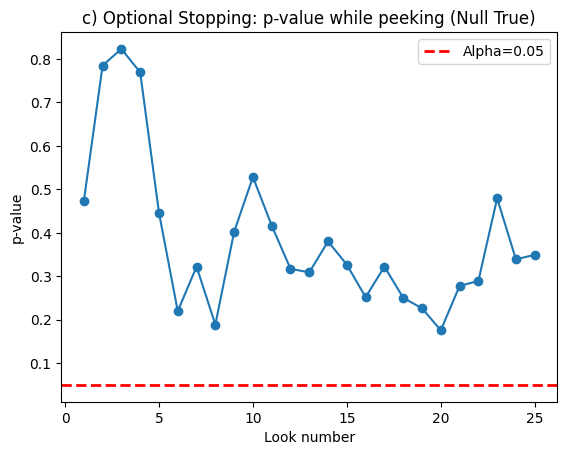

{'min_p_value_seen': np.float64(0.17577587263678407)}


In [13]:
def run_optional_stopping_analysis():
    steps = 25
    n_per_step = 2500
    p0 = 0.02
    p1 = 0.02  # null true
    pvals = []
    cum_c = cum_t = cum_nc = cum_nt = 0

    for _ in range(steps):
        c = np.random.binomial(n_per_step, p0)
        t = np.random.binomial(n_per_step, p1)
        cum_c += c
        cum_t += t
        cum_nc += n_per_step
        cum_nt += n_per_step

        # Calculate p-value
        _, pv = proportions_ztest([cum_t, cum_c], [cum_nt, cum_nc])
        pvals.append(pv)

    # Define the variable you are trying to return
    # Targeted simulation: Focuses exclusively on the Optional Stopping problem
    # It generates a single line plot showing how p-values fluctuate
    # (a "random walk") as you repeatedly peek at accumulating data

    min_p_value_seen = min(pvals)

    plt.figure()
    plt.plot(np.arange(1, steps + 1), pvals, marker='o') # Added marker for clarity
    plt.axhline(0.05, color = 'red', linestyle = "--", linewidth=2, label="Alpha=0.05")
    plt.title("c) Optional Stopping: p-value while peeking (Null True)")
    plt.xlabel("Look number")
    plt.ylabel("p-value")
    plt.legend()

    # Ensure _save_fig is defined elsewhere in your script
    _save_fig("C_optional_stopping_null_true.png")
    plt.show()
    plt.close()

    return {"min_p_value_seen": min_p_value_seen}

# Call the function and print the result
result = run_optional_stopping_analysis()
print(result)

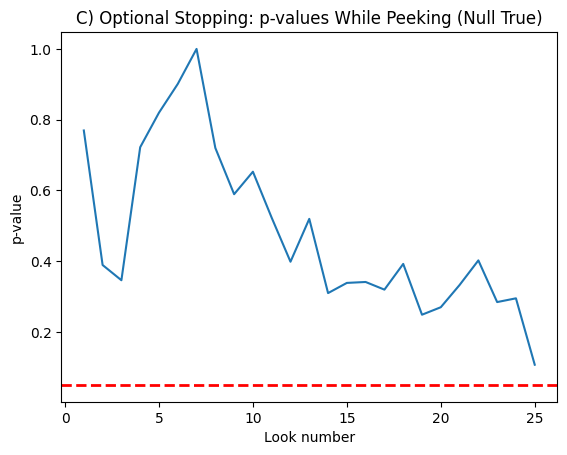

{'min_pvalue_seen': 0.1071357001099285}


In [14]:
def c_lln_clt_optional_stopping():
    # CLT: sampling distribution of mean CTR
    p_true = 0.02
    for n in [50, 500, 5000]:
        means = [np.mean(np.random.binomial(1, p_true, size=n)) for _ in range(3000)]
        plt.figure()
        plt.hist(means, bins=40)
        plt.title(f"C) Sampling Distribution of Mean CTR (n={n})")
        plt.xlabel("Mean CTR")
        plt.ylabel("Frequency")
        _save_fig(f"C_sampling_mean_ctr_n{n}.png")
        plt.close()

    # (Foundational Simulation): Adds a CLT simulation before the stopping analysis.
    # It generates three histograms showing the sampling distribution of the mean CTR.
    # This demonstrates that as your sample size ($n$) increases, the distribution of the mean becomes tighter and more normal
    # a concept you’ve applied when designing experiment guardrails.


    # Optional stopping: peeking under the null
    steps = 25
    n_per_step = 2500
    p0 = 0.02
    p1 = 0.02  # null true
    pvals = []
    cum_c = cum_t = cum_nc = cum_nt = 0
    for _ in range(steps):
        c = np.random.binomial(n_per_step, p0)
        t = np.random.binomial(n_per_step, p1)
        cum_c += c
        cum_t += t
        cum_nc += n_per_step
        cum_nt += n_per_step
        _, pv = proportions_ztest([cum_t, cum_c], [cum_nt, cum_nc])
        pvals.append(pv)

    plt.figure()
    plt.plot(np.arange(1, steps+1), pvals)
    plt.axhline(0.05, color = 'red', linestyle="--", linewidth=2)
    plt.title("C) Optional Stopping: p-values While Peeking (Null True)")
    plt.xlabel("Look number")
    plt.ylabel("p-value")
    _save_fig("C_optional_stopping_pvalues.png")
    plt.show()
    plt.close()

    return {"min_pvalue_seen": float(np.min(pvals))}

result = c_lln_clt_optional_stopping()
print(result)

demonstrates First Principles. You aren't just showing that "peeking is bad"; you are showing the underlying mathematical reason (CLT/Sampling Distributions) that makes the Z-test valid in the first place. This reflects your resume's strength in Causal Inference and Experimental Design.

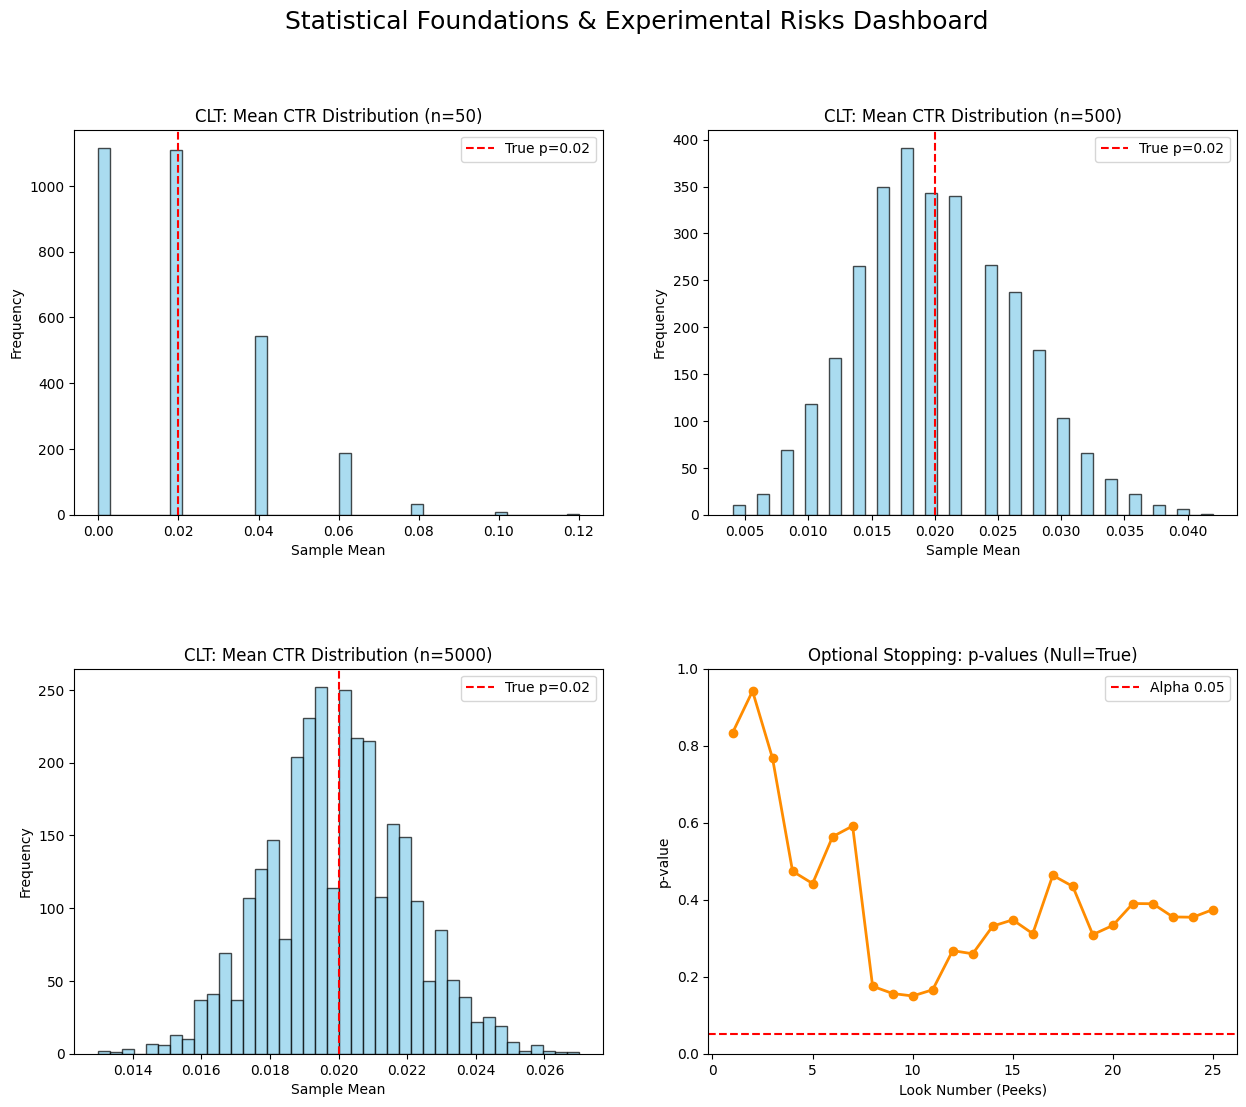

Minimum p-value encountered during peeking: 0.1500


In [15]:
def run_combined_simulation():
    # Setup for the 2x2 Dashboard
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.4)

    # 1. CLT SECTION: Sampling Distribution of the Mean
    p_true = 0.02
    sample_sizes = [50, 500, 5000]
    # We'll plot the first 3 subplots as the CLT histograms
    clt_axes = [axes[0, 0], axes[0, 1], axes[1, 0]]

    for idx, n in enumerate(sample_sizes):
        # Generate 3000 experiment simulations for each n
        means = [np.mean(np.random.binomial(1, p_true, size=n)) for _ in range(3000)]

        ax = clt_axes[idx]
        ax.hist(means, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
        ax.axvline(p_true, color='red', linestyle='--', label=f'True p={p_true}')
        ax.set_title(f"CLT: Mean CTR Distribution (n={n})")
        ax.set_xlabel("Sample Mean")
        ax.set_ylabel("Frequency")
        ax.legend()

    # 2. OPTIONAL STOPPING SECTION: The p-value Random Walk
    steps = 25
    n_per_step = 2500
    p0, p1 = 0.02, 0.02  # Null is True
    pvals = []
    cum_c = cum_t = cum_nc = cum_nt = 0

    for _ in range(steps):
        c = np.random.binomial(n_per_step, p0)
        t = np.random.binomial(n_per_step, p1)
        cum_c += c
        cum_t += t
        cum_nc += n_per_step
        cum_nt += n_per_step

        _, pv = proportions_ztest([cum_t, cum_c], [cum_nt, cum_nc])
        pvals.append(pv)

    # Plot the Optional Stopping in the final quadrant
    ax_stop = axes[1, 1]
    ax_stop.plot(np.arange(1, steps+1), pvals, marker='o', color='darkorange', linewidth=2)
    ax_stop.axhline(0.05, color='red', linestyle='--', label='Alpha 0.05')
    ax_stop.set_title("Optional Stopping: p-values (Null=True)")
    ax_stop.set_xlabel("Look Number (Peeks)")
    ax_stop.set_ylabel("p-value")
    ax_stop.set_ylim(0, 1)
    ax_stop.legend()

    plt.suptitle("Statistical Foundations & Experimental Risks Dashboard", fontsize=18)
    plt.show()

    return {"min_p_value": min(pvals)}

# Execute
stats_result = run_combined_simulation()
print(f"Minimum p-value encountered during peeking: {stats_result['min_p_value']:.4f}")

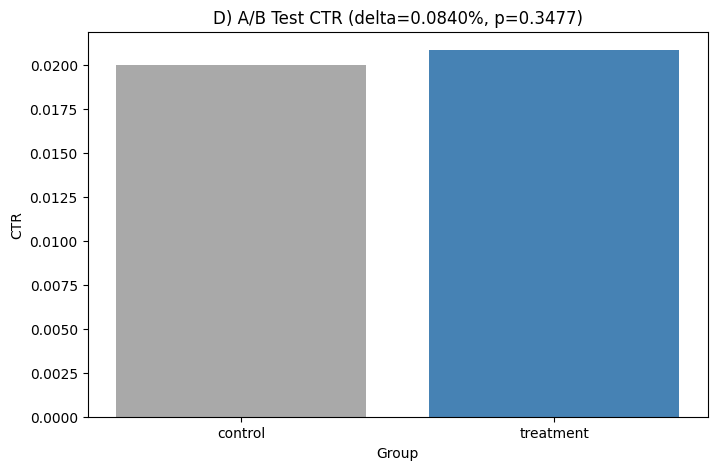

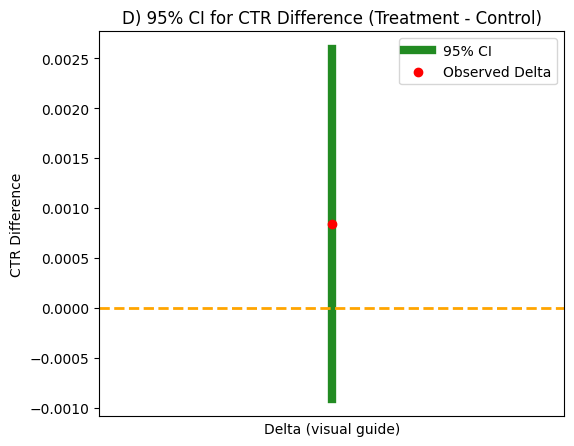

{
    "ctr_control": "2.0000%",
    "ctr_treatment": "2.0840%",
    "delta": "0.0840%",
    "p_value": "0.3477",
    "ci_range": [
        "-0.0913%",
        "0.2593%"
    ]
}


In [16]:
def d_hypothesis_testing():
    # Two proportion z-test example
    n_c = 50000
    n_t = 50000
    clicks_c = 1000
    clicks_t = 1042

    # Calculate statistics
    z, p_val = proportions_ztest([clicks_t, clicks_c], [n_t, n_c])
    ctr_c = clicks_c / n_c
    ctr_t = clicks_t / n_t
    delta = ctr_t - ctr_c

    # Calculate Confidence Interval (95%)
    se = math.sqrt(ctr_t * (1-ctr_t)/n_t + ctr_c * (1-ctr_c)/n_c)
    ci_low = delta - 1.96*se
    ci_high = delta + 1.96*se

    # Graph 1: CTR Comparison Bar Chart
    plt.figure(figsize=(8, 5))
    plt.bar(["control", "treatment"], [ctr_c, ctr_t], color=['#A9A9A9', '#4682B4'])
    plt.title(f"D) A/B Test CTR (delta={delta:.4%}, p={p_val:.4f})")
    plt.xlabel("Group")
    plt.ylabel("CTR")
    plt.show()
    plt.close()

    # Graph 2: 95% Confidence Interval for Delta
    plt.figure(figsize=(6, 5))
    plt.plot([0,0], [ci_low, ci_high], linewidth=6, color='#228B22', label='95% CI')
    plt.scatter([0], [delta], color='red', zorder=5, label='Observed Delta')
    plt.axhline(0, color = 'orange', linestyle="--", linewidth=2)
    plt.title(f"D) 95% CI for CTR Difference (Treatment - Control)")
    plt.xlabel("Delta (visual guide)")
    plt.ylabel("CTR Difference")
    plt.xticks([])
    plt.legend()
    plt.show()
    plt.close()

    return {
        "ctr_control": f"{ctr_c:.4%}",
        "ctr_treatment": f"{ctr_t:.4%}",
        "delta": f"{delta:.4%}",
        "p_value": f"{float(p_val):.4f}",
        "ci_range": (f"{ci_low:.4%}", f"{ci_high:.4%}")
    }

# Execute and capture results
test_results = d_hypothesis_testing()

# Display results
import json
print(json.dumps(test_results, indent=4))

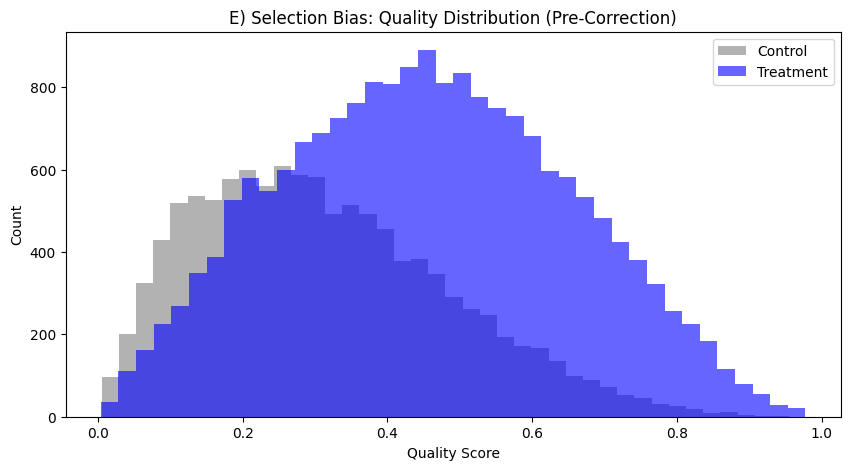

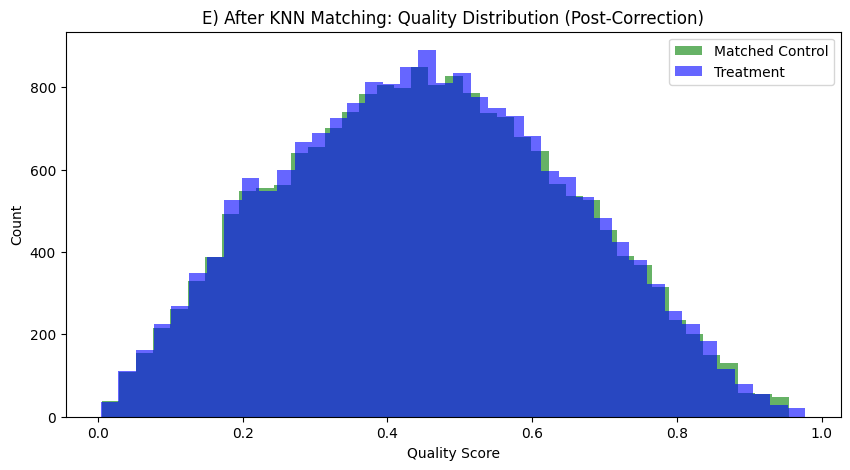

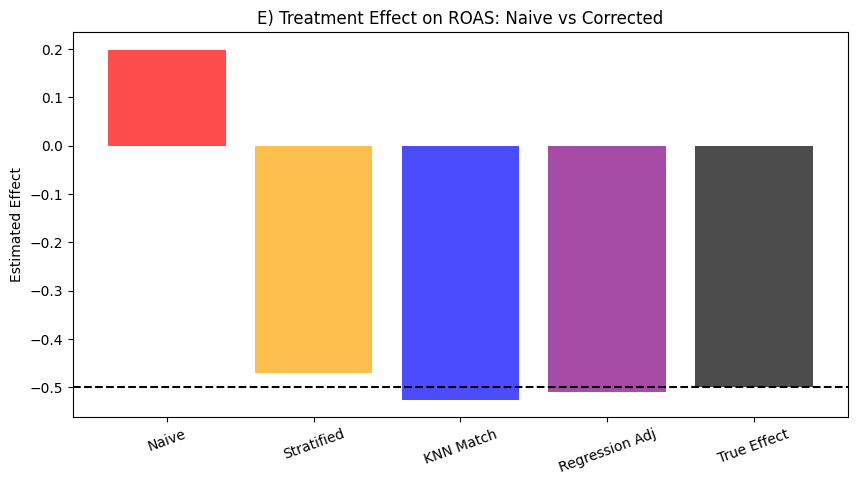

{
    "naive": 0.19891039596759885,
    "stratified": -0.46955207883188355,
    "knn": -0.5254416059399589,
    "reg_adj": -0.5105641105058728,
    "true": -0.5
}


In [17]:
def e_bias_correction():
    # Controlled example: true negative effect, naive looks +ve due to selection bias
    M = 30000
    df = pd.DataFrame({"id": np.arange(M)})
    df["quality"] = np.random.beta(2.0, 3.0, M)

    # Selection bias: high quality users are more likely to get treatment
    logit = -1.0 + 4.0 * df["quality"]
    p_treat = 1 / (1 + np.exp(-logit))
    df["treat"] = (np.random.rand(M) < p_treat).astype(int) # Fixed: aastype -> astype

    true_tau = -0.50
    noise = np.random.normal(0, 0.6, M)
    # ROAS depends heavily on quality, which creates the bias
    df["roas"] = 2.0 + 5.0 * df["quality"] + true_tau * df["treat"] + noise

    # 1. Naive Estimation (Biased)
    naive = df.loc[df["treat"] == 1, "roas"].mean() - df.loc[df["treat"] == 0, "roas"].mean()

    # 2. Stratified Estimation
    df["qbin"] = pd.qcut(df["quality"], q=6, labels=False)
    strata_results = [] # Renamed to avoid confusion
    for b in sorted(df["qbin"].unique()):
        s = df[df["qbin"] == b]
        diff = s.loc[s["treat"] == 1, "roas"].mean() - s.loc[s["treat"] == 0, "roas"].mean()
        w = len(s) / len(df)
        strata_results.append((diff, w))
    strat = sum(d * w for d, w in strata_results) # Fixed: start -> strata_results

    # 3. KNN Matching (Nearest Neighbors)
    control = df[df["treat"] == 0]
    treat = df[df["treat"] == 1]
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[["quality"]])
    _, idx = nn.kneighbors(treat[["quality"]])
    matched_control = control.iloc[idx.flatten()]
    knn_est = treat["roas"].mean() - matched_control["roas"].mean() # Fixed: lnn_est -> knn_est

    # 4. Regression Adjustment
    X = sm.add_constant(df[["treat", "quality"]])
    reg = sm.OLS(df["roas"], X).fit()
    reg_adj = float(reg.params["treat"])

    # --- Visualization ---

    # Plot 1: Selection Bias Evidence
    plt.figure(figsize=(10, 5))
    plt.hist(control["quality"], bins=40, alpha=0.6, label="Control", color='gray') # Fixed: missing comma
    plt.hist(treat["quality"], bins=40, alpha=0.6, label="Treatment", color='blue') # Fixed: alphs -> alpha
    plt.title("E) Selection Bias: Quality Distribution (Pre-Correction)")
    plt.xlabel("Quality Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()
    plt.close()

    # Plot 2: Post-Matching Balance
    plt.figure(figsize=(10, 5))
    plt.hist(matched_control["quality"], bins=40, alpha=0.6, label="Matched Control", color='green')
    plt.hist(treat["quality"], bins=40, alpha=0.6, label="Treatment", color='blue')
    plt.title("E) After KNN Matching: Quality Distribution (Post-Correction)")
    plt.xlabel("Quality Score")
    plt.ylabel("Count")
    plt.legend()
    plt.show()
    plt.close()

    # Plot 3: Method Comparison
    methods = ["Naive", "Stratified", "KNN Match", "Regression Adj", "True Effect"]
    estimates = [naive, strat, knn_est, reg_adj, true_tau]
    plt.figure(figsize=(10, 5))
    colors = ['red', 'orange', 'blue', 'purple', 'black']
    plt.bar(methods, estimates, color=colors, alpha=0.7)
    plt.axhline(true_tau, color='black', linestyle='--', label='Ground Truth')
    plt.title("E) Treatment Effect on ROAS: Naive vs Corrected")
    plt.ylabel("Estimated Effect")
    plt.xticks(rotation=20)
    plt.show()
    plt.close()

    return {
        "naive": float(naive),
        "stratified": float(strat),
        "knn": float(knn_est),
        "reg_adj": float(reg_adj),
        "true": float(true_tau)
    }

# Execute and display results
bias_results = e_bias_correction()
print(json.dumps(bias_results, indent=4))

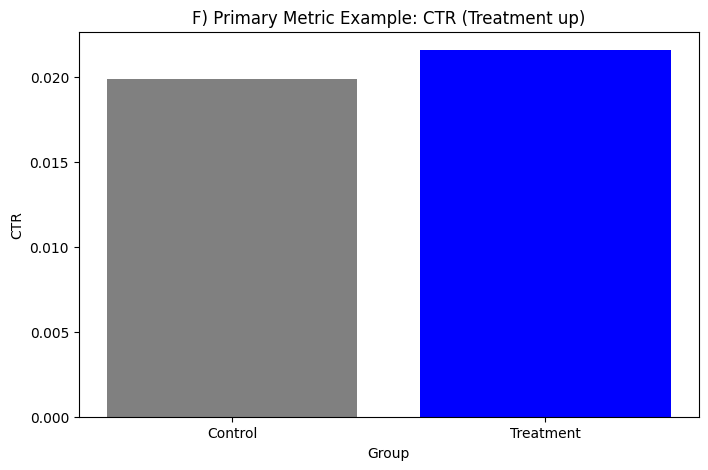

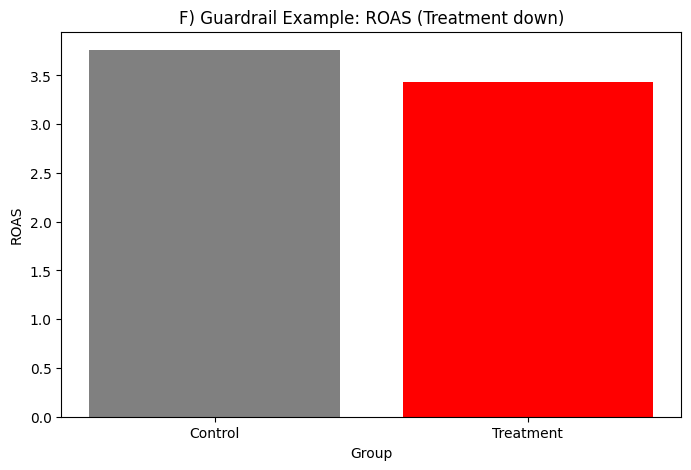

{
    "ctr_control": 0.01986537642051138,
    "ctr_treatment": 0.02155997844875103,
    "roas_control": 3.76089095328984,
    "roas_treatment": 3.428322836272655
}


In [18]:
def f_metrics_guardrails():
    # Campaign level example: CTR improves but ROAS declines
    K = 400 # Capitalized to match usage
    camp = pd.DataFrame({"campaign_id": np.arange(K)})
    camp["group"] = np.where(np.random.rand(K) < 0.5, "control", "treatment")

    # Simulating a scenario where CTR goes up but ROAS (the guardrail) goes down
    camp["ctr"] = np.random.normal(0.02, 0.004, K) + (camp["group"]=="treatment") * 0.0015
    camp["roas"] = np.random.normal(3.8, 0.6, K) + (camp["group"]=="treatment") * (-0.35)

    # Fixed: groupbt -> groupby; ensured lowercase matches column names
    summary = camp.groupby("group")[["ctr", "roas"]].mean()

    # Graph 1: Primary Metric (CTR)
    plt.figure(figsize=(8, 5))
    plt.bar(["Control", "Treatment"], [summary.loc["control", "ctr"],
                                      summary.loc["treatment", "ctr"]], color=['gray', 'blue'])
    plt.title("F) Primary Metric Example: CTR (Treatment up)")
    plt.xlabel("Group")
    plt.ylabel("CTR")
    plt.show()
    plt.close()

    # Graph 2: Guardrail Metric (ROAS)
    plt.figure(figsize=(8, 5))
    plt.bar(["Control", "Treatment"], [summary.loc["control", "roas"],
                                      summary.loc["treatment", "roas"]], color=['gray', 'red'])
    plt.title("F) Guardrail Example: ROAS (Treatment down)")
    plt.xlabel("Group")
    plt.ylabel("ROAS")
    plt.show()
    plt.close()

    return {
        "ctr_control": float(summary.loc["control", "ctr"]),
        "ctr_treatment": float(summary.loc["treatment", "ctr"]),
        "roas_control": float(summary.loc["control", "roas"]),
        "roas_treatment": float(summary.loc["treatment", "roas"])
    }

# Function call to return graphs and result
guardrail_results = f_metrics_guardrails()
import json
print(json.dumps(guardrail_results, indent=4))

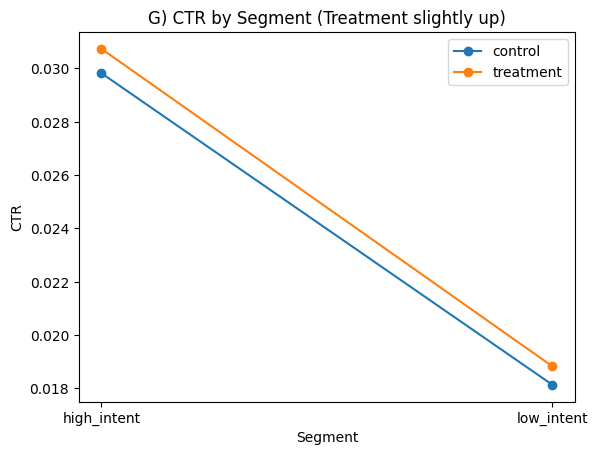

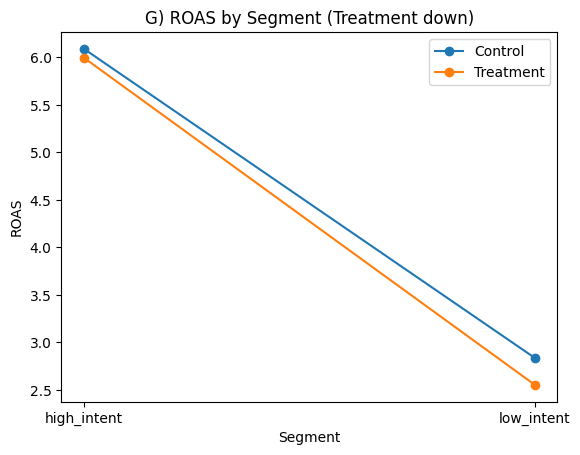

[
    {
        "group":"control",
        "segment":"high_intent",
        "ctr":0.0298212479,
        "roas":6.0895913419
    },
    {
        "group":"control",
        "segment":"low_intent",
        "ctr":0.0181317493,
        "roas":2.8371018798
    },
    {
        "group":"treatment",
        "segment":"high_intent",
        "ctr":0.0307380655,
        "roas":5.995810524
    },
    {
        "group":"treatment",
        "segment":"low_intent",
        "ctr":0.0188249956,
        "roas":2.5537044802
    }
]


In [19]:
def g_tradeoff_diagnosis():
    # Segment mix example (simpson-isg): CTR up, ROAS down
    S = 2000
    df = pd.DataFrame({"id": np.arange(S)})

    # CORRECTED: Changed size=5 to size=S (2000) so the lengths match
    df["segment"] = np.random.choice(["low_intent", "high_intent"], size=S, p=[0.75, 0.25])
    df["group"] = np.random.choice(["control", "treatment"], size=S, p=[0.5, 0.5])

    shift = (df["group"]=="treatment") & (np.random.rand(S) < 0.12)
    df.loc[shift, "segment"] = "low_intent"

    seg_ctr = {"low_intent": 0.018, "high_intent": 0.030}
    seg_roas = {"low_intent": 2.8, "high_intent": 6.2}
    df["ctr"] = [np.random.normal(seg_ctr[s], 0.004) for s in df["segment"]]
    df["roas"] = [np.random.normal(seg_roas[s], 0.9) for s in df["segment"]]
    df["ctr"] += (df["group"]=="treatment") * 0.0008
    df["roas"] += (df["group"]=="treatment") * (-0.25)

    seg_summary = df.groupby(["group", "segment"])[["ctr", "roas"]].mean().reset_index()

    pivot_ctr = seg_summary.pivot(index="segment", columns="group", values="ctr")
    plt.figure()
    # CORRECTED: astpype -> astype | maker -> marker
    plt.plot(pivot_ctr.index.astype(str), pivot_ctr["control"], marker="o", label="control")
    plt.plot(pivot_ctr.index.astype(str), pivot_ctr["treatment"], marker="o", label="treatment")
    plt.title("G) CTR by Segment (Treatment slightly up)")
    plt.xlabel("Segment")
    plt.ylabel("CTR")
    plt.legend()
    plt.show()
    plt.close()

    pivot_roas = seg_summary.pivot(index="segment", columns="group", values="roas")
    plt.figure()
    plt.plot(pivot_roas.index.astype(str), pivot_roas["control"], marker="o", label="Control")
    plt.plot(pivot_roas.index.astype(str), pivot_roas["treatment"], marker="o", label="Treatment")
    plt.title("G) ROAS by Segment (Treatment down)")
    plt.xlabel("Segment")
    plt.ylabel("ROAS")
    plt.legend()
    plt.show()
    plt.close()

    return seg_summary

tradeoff_result = g_tradeoff_diagnosis()
# CORRECTED: tradeoff_results -> tradeoff_result (to match function output)
print(tradeoff_result.to_json(orient="records", indent=4))

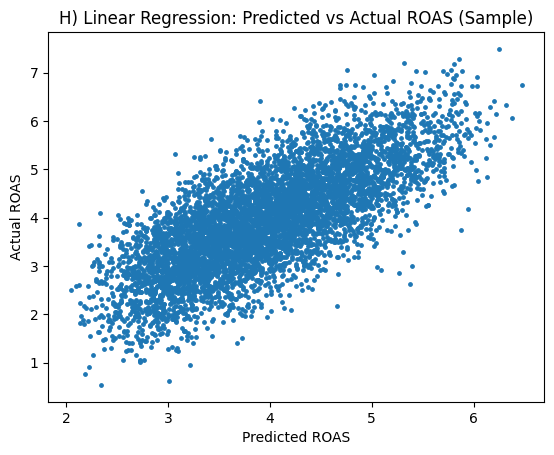

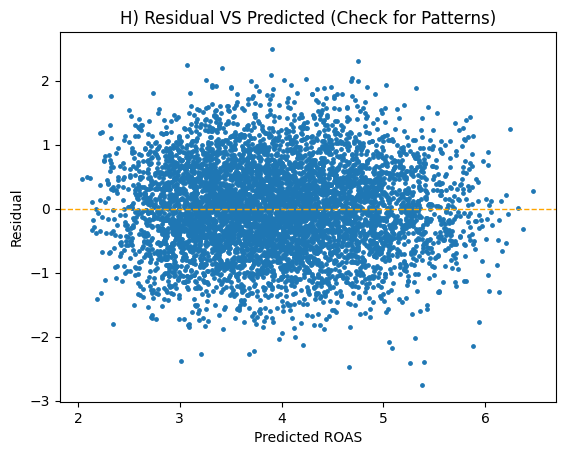

const      0.477136
treat     -1.034474
quality    2.065671
cpc        2.236475
dtype: float64


In [20]:
def h_linear_regression():
  # Simple regression interpretation
  R = 15000
  df = pd.DataFrame({"id": np.arange(R)})
  df["quality"] = np.random.beta(2.0, 3.0, R)
  logit = -1.2 + 3.6 * df["quality"]
  df["treat"] = (np.random.rand(R) < (1/(1+np.exp(-logit)))).astype(int)
  df["cpc"] = 0.9 + 1.0 * df["quality"] + 0.25 * df["treat"]
  df["roas"] = 2.2 + 4.8 * df["quality"] - 0.35 * df["treat"] - 0.5*(df["cpc"]-1.5) + np.random.normal(0, 0.7, R)
  X = sm.add_constant(df[["treat", "quality", "cpc"]])
  model = sm.OLS(df["roas"], X).fit()
  df["roas_hat"] = model.predict(X)
  df["resid"] = df["roas"] - df["roas_hat"]

  samp = df.sample(min(6000, len(df)), random_state=1)
  plt.figure()
  plt.scatter(samp["roas_hat"], samp["roas"], s=6)
  plt.title("H) Linear Regression: Predicted vs Actual ROAS (Sample)")
  plt.xlabel("Predicted ROAS")
  plt.ylabel("Actual ROAS")
  _save_fig("H_pred_vs_actual_roas_lin_reg.png")
  plt.show()
  plt.close()

  plt.figure()
  plt.scatter(samp["roas_hat"], samp["resid"], s=6)
  plt.axhline(0, color = "orange", linestyle="--", linewidth=1)
  plt.title("H) Residual VS Predicted (Check for Patterns)")
  plt.xlabel("Predicted ROAS")
  plt.ylabel("Residual")
  _save_fig("H_residuals_vs_pred.png")
  plt.show()
  plt.close()

  return model.params

linear_regression_result = h_linear_regression()
print(linear_regression_result)



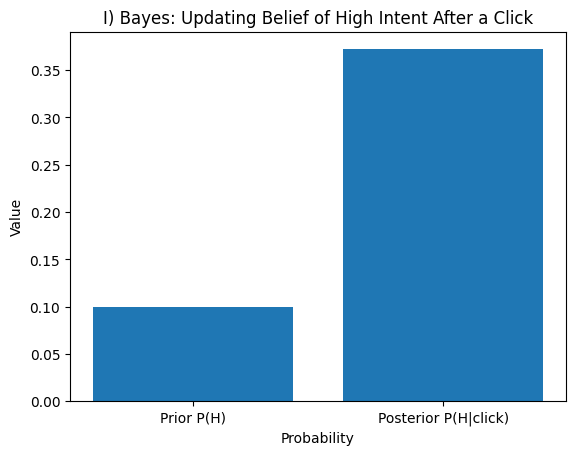

{'prior': 0.1, 'posterior': 0.372093023255814}


In [21]:
def i_bayes():
  # Bayes posterior example
  p_H = 0.10
  p_click_H = 0.08
  p_click_notH = 0.015
  p_click_total = p_click_H * p_H + p_click_notH * (1-p_H)
  p_H_click = (p_click_H * p_H) / p_click_total

  plt.figure()
  plt.bar(["Prior P(H)", "Posterior P(H|click)"], [p_H, p_H_click])
  plt.title("I) Bayes: Updating Belief of High Intent After a Click")
  plt.xlabel("Probability")
  plt.ylabel("Value")
  _save_fig("I_bayes_update.png")
  plt.show()
  plt.close()

  return {"prior": p_H, "posterior": p_H_click}

bayes_result = i_bayes()
print(bayes_result)

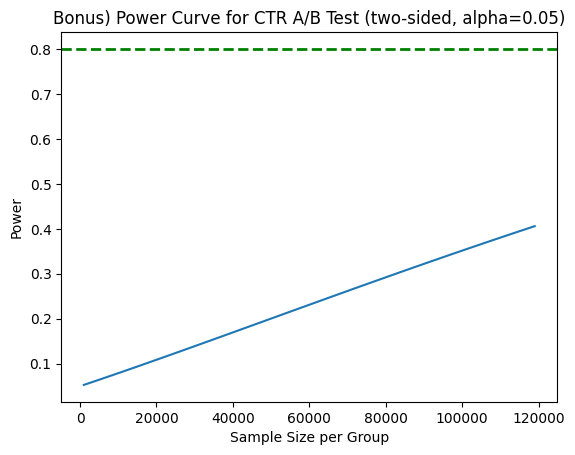

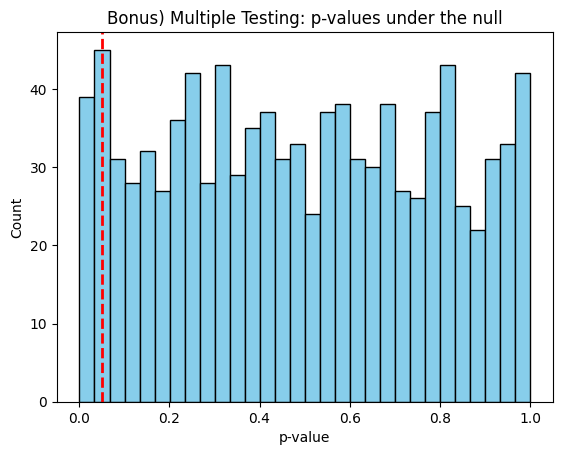

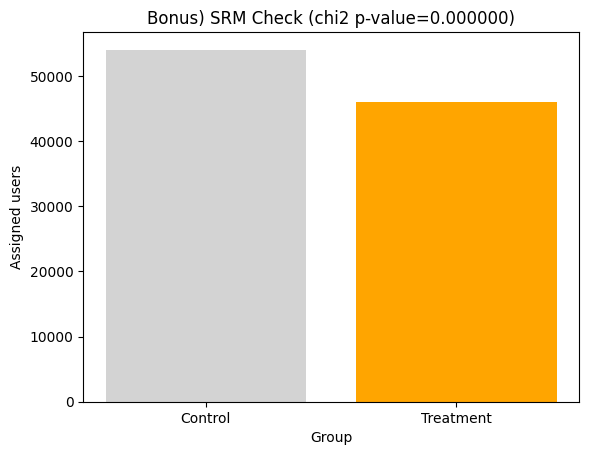

{'n_required_80_power': 315160.0623953832, 'false_positives_0p05_of_1000': 64, 'srm_p': 3.3414880386413873e-141}


In [22]:
def bones_power_multiple_testing_srm():
    # power curve
    p0 = 0.020
    mde = 0.0010
    p1 = p0 + mde
    effect = proportion_effectsize(p1, p0)
    analysis = NormalIndPower()
    alpha = 0.05
    power_target = 0.80

    n_grid = np.arange(1000, 120000, 2000)
    # FIXED: Changed "two_sided" to "two-sided" (hyphen) and bons1 to nobs1
    power = analysis.power(effect_size=effect, nobs1=n_grid, alpha=alpha,
                           ratio=1.0, alternative="two-sided")

    plt.figure()
    plt.plot(n_grid, power)
    plt.axhline(power_target, color="green", linestyle="--", linewidth=2)
    plt.title("Bonus) Power Curve for CTR A/B Test (two-sided, alpha=0.05)")
    plt.xlabel("Sample Size per Group")
    plt.ylabel("Power")
    plt.show()
    plt.close()

    # FIXED: Changed "two_sided" to "two-sided"
    n_required = analysis.solve_power(effect_size=effect, power=power_target,
                                       alpha=alpha, ratio=1.0, alternative="two-sided")

    # multiple testing under null
    np.random.seed(23)
    num_tests = 1000
    pvals_list = []
    n = 20000

    for _ in range(num_tests):
        c = np.random.binomial(n, p0)
        t = np.random.binomial(n, p0)
        phat_c = c/n
        phat_t = t/n
        p_pool = (c+t)/(2*n)
        se = math.sqrt(p_pool * (1-p_pool) * (2/n))
        z = (phat_t - phat_c) / se if se > 0 else 0
        pv = 2*(1-norm.cdf(abs(z)))
        pvals_list.append(pv)

    pvals = np.array(pvals_list)

    plt.figure()
    plt.hist(pvals, bins=30, color='skyblue', edgecolor='black')
    plt.axvline(alpha, color="red", linestyle="--", linewidth=2)
    plt.title("Bonus) Multiple Testing: p-values under the null")
    plt.xlabel("p-value")
    plt.ylabel("Count")
    plt.show()
    plt.close()

    # FIXED: Use 'pvals' (the numpy array) instead of 'pval' (the list)
    false_positives = int((pvals < 0.05).sum())

    # SRM Example
    expected = np.array([50000, 50000])
    observed = np.array([54000, 46000])
    # FIXED: f_exp instead of g_exp
    chi2, p_srm = chisquare(f_obs=observed, f_exp=expected)

    plt.figure()
    plt.bar(["Control", "Treatment"], observed, color=['lightgrey', 'orange'])
    plt.title(f"Bonus) SRM Check (chi2 p-value={p_srm:.6f})")
    plt.xlabel("Group")
    plt.ylabel("Assigned users")
    plt.show()
    plt.close()

    return {
        "n_required_80_power": float(n_required),
        "false_positives_0p05_of_1000": false_positives,
        "srm_p": float(p_srm)
    }

bonus_result = bones_power_multiple_testing_srm()
print(bonus_result)

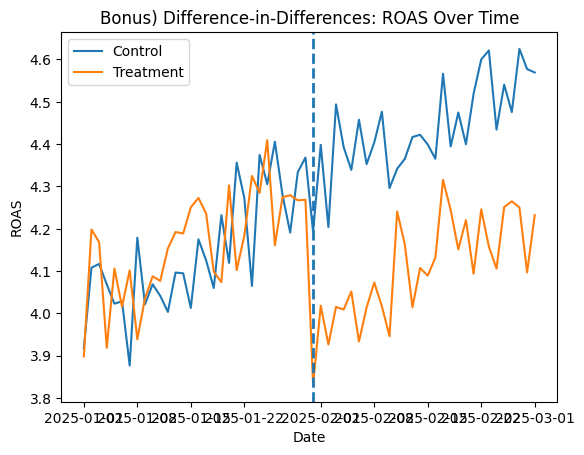

-0.34832291412715133


In [23]:
def bonus_did():
    days = pd.date_range("2025-01-01", periods=60, freq="D")
    ts = pd.DataFrame({"date": days})
    ts["post"] = (ts["date"] >= days[30]).astype(int)
    ts["control_roas"] = 4.0 + 0.01*np.arange(60) + np.random.normal(0, 0.08, 60)
    ts["treat_roas"]   = 4.0 + 0.01*np.arange(60) + np.random.normal(0, 0.08, 60) + ts["post"]*(-0.35)

    pre_c = ts.loc[ts["post"]==0, "control_roas"].mean()
    post_c = ts.loc[ts["post"]==1, "control_roas"].mean()
    pre_t = ts.loc[ts["post"]==0, "treat_roas"].mean()
    post_t = ts.loc[ts["post"]==1, "treat_roas"].mean()
    did = (post_t - pre_t) - (post_c - pre_c)

    plt.figure()
    plt.plot(ts["date"], ts["control_roas"], label="Control")
    plt.plot(ts["date"], ts["treat_roas"], label="Treatment")
    plt.axvline(days[30], linestyle="--", linewidth=2)
    plt.title("Bonus) Difference-in-Differences: ROAS Over Time")
    plt.xlabel("Date")
    plt.ylabel("ROAS")
    plt.legend()
    _save_fig("BONUS_did_time_series.png")
    plt.show()
    plt.close()


    return float(did)
did_result = bonus_did()
print(did_result)